# Aim

Inverse detection efficiency completeness calculation on TESS data. Currently only uses geometric probabilities.

IDEM as in Appendix A of Hsu 2018 (https://arxiv.org/pdf/1803.10787.pdf).

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from tqdm.notebook import tqdm
from os import path
from dev import utils

%load_ext autoreload
%autoreload 2

In [3]:
stellar = utils.get_tess_stellar().drop_duplicates("ID")
print("Initial number of targets: {}".format(len(stellar)))
stellar = stellar[np.isfinite(stellar['rad'])]
stellar = stellar[np.isfinite(stellar['mass'])]
print("Cut to {} targets".format(len(stellar)))

Initial number of targets: 244730
Cut to 189744 targets


In [4]:
planetary = utils.get_tois(force_redownload=True)
exclude_candidates = True
print("Initial number of TOIs: {}".format(len(planetary)))
if exclude_candidates:
    planetary = planetary[np.logical_or(planetary["toi_pdisposition"] == "KP", planetary["toi_pdisposition"] == "CP")]
planetary = planetary[np.isfinite(planetary['toi_prad'])]
planetary = planetary[np.isfinite(planetary['toi_period'])]
print("Cut to {} TOIs".format(len(planetary)))

Retrieving TOI table from https://tev.mit.edu/data/collection/193/csv/6/.
Initial number of TOIs: 2173
Cut to 250 TOIs


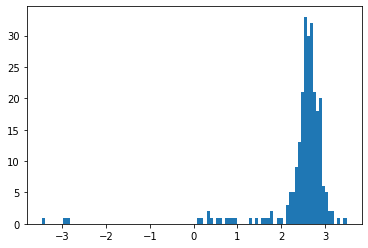

In [5]:
# let's group all these planets into buckets based on planet size and orbital period!
radii = np.array(planetary['toi_prad'])
_ = plt.hist(np.log(radii), bins=100)

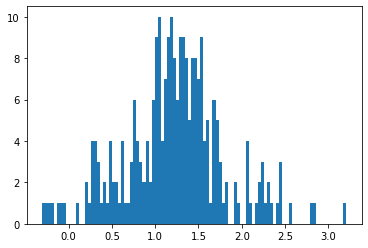

In [6]:
periods = np.array(planetary['toi_period'])
_ = plt.hist(np.log(periods), bins=100)

In [7]:
long_planets = planetary[planetary["toi_period"] > 27.4]
for planet in long_planets.iterrows():
    planet = planet[1]
    num_sectors = len(planet["sectors"].split())
    if planet["toi_period"] > 27.4 * num_sectors:
        print("TOI {0} has a period of {1} days and was observed in {2} sectors.".format(planet["toi_id"], planet["toi_period"], num_sectors))
        print("Public comment on this TOI: {}".format(planet["comment"]))

exomast: plug in the name of the planet, get all the observations
https://exo.mast.stsci.edu/

Text(0, 0.5, 'Log-radius (ln Earth radii)')

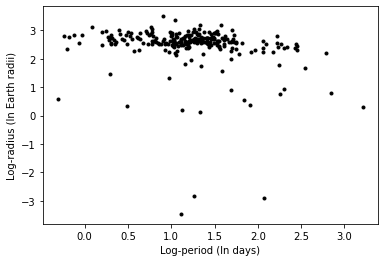

In [8]:
plt.plot(np.log(periods), np.log(radii), ".k")
plt.xlabel("Log-period (ln days)")
plt.ylabel("Log-radius (ln Earth radii)")

In [9]:
# planetary = planetary[planetary['TOI Disposition'] == "PC"]
combined = pd.merge(planetary, stellar, left_on="TIC", right_on="ID")
periods = combined['toi_period'].values
prads = combined['toi_prad'].values
len(combined)

200

In [10]:
def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    # dfm.io/posts/exopop
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

pgeoms = combined['rad'].values / get_a(periods, combined['mass'].values)

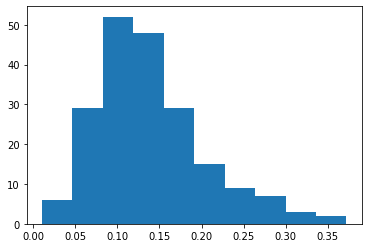

In [11]:
_ = plt.hist(pgeoms)

In [27]:
def pcomp(period, rstars=stellar['rad'].values, mstars=stellar['mass'].values):
    '''
    For each of the stars in the stellar catalog, computes the probability of detection 
    of the planet with the given period and radius 
    
    Arguments
    ---------
    stellar : pd.DataFrame
    The full stellar catalog, as extracted from the merge on MAST and the MIT TEV database.
    
    period : scalar
    The period value for the TOI, in days.
    
    prad : scalar
    The radius value for the TOI, in R_Earths.

    Returns
    -------
    pcomps : np.ndarray
    The probability of each of the detections.
    '''
    pgeoms = rstars / get_a(period, mstars)
    return pgeoms

In [30]:
ij_filename = '../data/idem_pdets_{}.npy'.format(exclude_candidates)
if not path.exists(ij_filename):
    pdet_ij = np.empty((len(periods), len(stellar)))
    for i, period in enumerate(tqdm(periods, total=len(combined))):
        pdet_ij[i] = pcomp(period)
    np.save(ij_filename, pdet_ij)
else:
    pdet_ij = np.load(ij_filename)

In [31]:
i_filename = '../data/idem_pdets_i.npy'.format(exclude_candidates)
if not path.exists(i_filename):
    pdet_i = np.nanmean(pdet_ij, axis=1)
    np.save(i_filename, pdet_i)
else:
    pdet_i = np.load(i_filename)

(array([16., 16., 67., 49., 17., 10., 11.,  1.,  3.,  4.]),
 array([0.0307532 , 0.05968762, 0.08862205, 0.11755648, 0.14649091,
        0.17542533, 0.20435976, 0.23329419, 0.26222862, 0.29116304,
        0.32009747]),
 <a list of 10 Patch objects>)

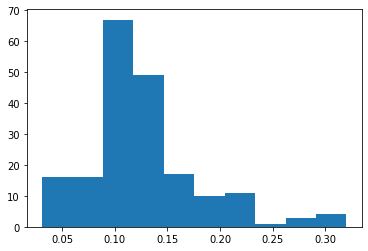

In [32]:
plt.hist(pdet_i)

In [12]:
weights = np.nan_to_num(1 / pgeoms)

In [13]:
period_bins = np.array([0.5, 1.25, 2.5, 5, 10, 20, 40, 80, 160, 320])
rp_bins = np.array([0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 6, 8, 12, 16])
counts = np.histogram2d(periods, prads, bins=[period_bins, rp_bins])[0]
N = np.histogram2d(periods, prads, bins=[period_bins, rp_bins], weights=weights)
f = N[0] / len(stellar)

Text(0.5, 1.0, 'TESS completeness: exclude candidates = True')

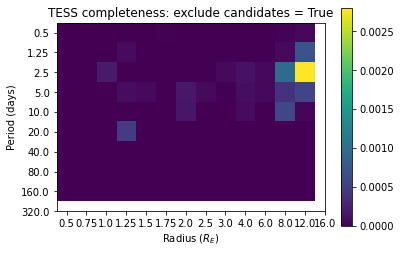

In [14]:
plt.imshow(f)
plt.colorbar()
_ = plt.xticks(list(range(len(rp_bins))), rp_bins)
plt.xlabel(r"Radius ($R_E$)")
_ = plt.yticks(list(range(len(period_bins))), period_bins)
plt.ylabel("Period (days)")
plt.title("TESS completeness: exclude candidates = {}".format(exclude_candidates))

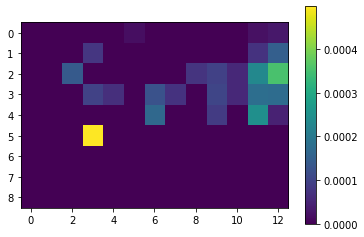

In [15]:
sigmas = np.divide(f, np.sqrt(counts), out=np.zeros_like(f), where=counts!=0)
plt.imshow(sigmas)
plt.colorbar()